In [1]:
#!~/anaconda3/envs/bottomup/bin/python
"""
单独测试Omni检测器的单轮检测
将检测到的对象加入向量数据库
"""

import sys
import os
import io
import base64
import yaml
import cv2
from PIL import Image
import numpy as np
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 添加项目路径
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from BottomUpAgent.Detector import Detector
from BottomUpAgent.LongMemory import LongMemory
from BottomUpAgent.VectorMemory import VectorMemory
from BottomUpAgent.Eye import Eye


/home/jch/anaconda3/envs/bottomup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jch/anaconda3/envs/bottomup/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:715: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /home/jch/.paddlex/official_models.
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /home/jch/.paddlex/official_mode

In [2]:


def load_config():
    """加载配置文件"""
    config_paths = [
        "config/slay_the_spire_vector_config.yaml",
        "configs/sts_omni_claude.yaml"
    ]
    
    for config_path in config_paths:
        if os.path.exists(config_path):
            with open(config_path, 'r', encoding='utf-8') as f:
                config = yaml.safe_load(f)
            
            # 确保使用omni检测器
            if 'detector' not in config:
                config['detector'] = {}
            config['detector']['type'] = 'omni'
            
            print(f"✓ 使用配置文件: {config_path}")
            return config
    
    print("✗ 未找到可用的配置文件")
    return None


In [3]:

"""测试Omni检测器单轮检测"""
print("=== Omni检测器单轮测试 ===\n")

# 1. 加载配置
config = load_config()


=== Omni检测器单轮测试 ===

✓ 使用配置文件: config/slay_the_spire_vector_config.yaml


In [4]:

# 2. 初始化组件
try:
    print("初始化Detector...")
    detector = Detector(config)
    
    print("初始化LongMemory...")
    long_memory = LongMemory(config)
    vector_memory = long_memory.vector_memory
    
    print("✓ 组件初始化成功")
    print(f"检测器类型: {detector.detector_type}")
    
except Exception as e:
    print(f"✗ 组件初始化失败: {e}")
    import traceback
    traceback.print_exc()


初始化Detector...
load som model from  ./weights/icon_detect/model.pt
Omniparser initialized!!!
cuda:0 <class 'ultralytics.models.yolo.model.YOLO'>
初始化LongMemory...


[2025-08-10 20:03:15,388] [   ERROR] VectorMemory.py:829 - 清空数据库失败: Collection [ui_objects] does not exists


Use open_clip to embed in the vector database.
✓ 组件初始化成功
检测器类型: omni


In [5]:

eye = Eye(config)
test_image_or_path = eye.get_screenshot_cv()
try:
    if test_image_or_path is not None:
        pass
except Exception as e:
    print("✗ 未找到可用的测试图像")

print(f"✓ 窗口截图加载成功")
image = test_image_or_path
print(f"图像尺寸: {image.shape}")


screenshot mode: RGB
✓ 窗口截图加载成功
图像尺寸: (1080, 1920, 3)


In [6]:

# 4. 清空向量数据库（确保干净的测试环境）
print("\n--- 清空向量数据库 ---")
# try:
#     vector_memory.clear_database()
#     print("✓ 向量数据库已清空")
# except Exception as e:
#     print(f"清空数据库时出现警告: {e}")




--- 清空向量数据库 ---


In [7]:

# 5. 使用Omni检测对象
print("\n--- Omni对象检测 ---")
try:
    detected_objects, labled_img = detector.extract_objects_omni(image)
    print(f"✓ 检测完成，共检测到 {len(detected_objects)} 个对象")
    
    # 显示前几个检测结果的详细信息
    print("\n检测结果详情:")
    for i, obj in enumerate(detected_objects):
        content = obj.get('content', 'N/A')
        bbox = obj['bbox']
        area = obj['area']
        type = obj['type']
        center = obj['center']
        
        print(f"OBJECT {i+1}:")
        print(f"  type: '{type}'")
        print(f"  content: '{content}'")
        print(f"  bbox: {bbox}")
        print(f"  area: {area}")
        print(f"  center_pos: {center}")
        print(f"  size_pixel: {obj['image'].shape}")
        print()
    
except Exception as e:
    print(f"✗ 检测失败: {e}")
    import traceback
    traceback.print_exc()



--- Omni对象检测 ---

0: 736x1280 8 icons, 45.3ms
Speed: 3.8ms preprocess, 45.3ms inference, 28.9ms postprocess per image at shape (1, 3, 736, 1280)
time to get parsed content: 0.1295459270477295
NUM of boxes: 31 OCR: 25 icons: 6


/home/jch/anaconda3/envs/bottomup/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


✓ 检测完成，共检测到 31 个对象

检测结果详情:
OBJECT 1:
  type: 'text'
  content: 'Junchu'
  bbox: [23, 17, 102, 29]
  area: 2958
  center_pos: (74, 31)
  size_pixel: (29, 102, 3)

OBJECT 2:
  type: 'text'
  content: 'the Ironclad'
  bbox: [136, 21, 118, 24]
  area: 2832
  center_pos: (195, 33)
  size_pixel: (24, 118, 3)

OBJECT 3:
  type: 'text'
  content: '[V2.3.4] (12-18-2022)'
  bbox: [1700, 75, 204, 27]
  area: 5508
  center_pos: (1802, 88)
  size_pixel: (27, 204, 3)

OBJECT 4:
  type: 'text'
  content: '2343PEDP881JM'
  bbox: [1733, 102, 172, 20]
  area: 3440
  center_pos: (1819, 112)
  size_pixel: (20, 172, 3)

OBJECT 5:
  type: 'text'
  content: '49/49'
  bbox: [1395, 741, 69, 29]
  area: 2001
  center_pos: (1429, 755)
  size_pixel: (29, 69, 3)

OBJECT 6:
  type: 'text'
  content: '80/80'
  bbox: [437, 759, 75, 27]
  area: 2025
  center_pos: (474, 772)
  size_pixel: (27, 75, 3)

OBJECT 7:
  type: 'text'
  content: '2'
  bbox: [749, 804, 21, 30]
  area: 630
  center_pos: (759, 819)
  size_pixel: 

--- 生成检测结果可视化 ---


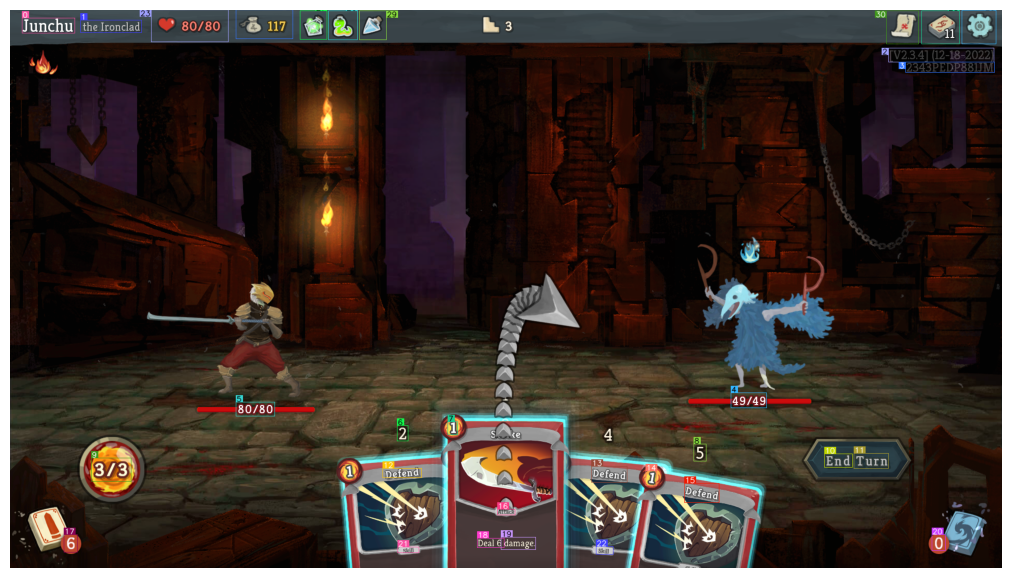

In [8]:

# 6. 可视化检测结果
print("--- 生成检测结果可视化 ---")
try:
    # save labled_img to scripts/omni_detection_result.png
    # Image.open(io.BytesIO(base64.b64decode(labled_img))).save(f'scripts/omni_detection_result.png')

    # in Notebook, plot directly to the following output
    img = Image.open(io.BytesIO(base64.b64decode(labled_img)))
    plt.figure(figsize=(12.8, 10.8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
except Exception as e:
    print(f"可视化生成失败: {e}")


In [9]:

# 7. 连接到向量数据库
print("--- 存储到向量数据库 ---")
# state = create_vector_state(detected_objects)

try:
    # 显示向量数据库统计
    stats = vector_memory.get_collection_stats()
    print(f"向量数据库统计: {stats}")
    
except Exception as e:
    print(f"✗ 存储失败: {e}")
    import traceback
    traceback.print_exc()


--- 存储到向量数据库 ---
向量数据库统计: {'total_objects': 0, 'game_name': 'Slay the Spire', 'vector_dim': 512, 'db_path': './data/vector/slay_the_spire'}


In [10]:

# 8. 测试逐个向量数据库存储操作
print("\n--- 逐个向量数据库存储操作测试 ---")

# 测试单个对象存储
# for i, obj in enumerate(detected_objects):
#     try:
#         stored_id = vector_memory.store_object(obj)
#         print(f"✓ 单个对象存储成功: {stored_id}")
        
#         # # 测试相似对象查找
#         similar_objects = vector_memory.find_similar_objects(obj, top_k=3)
#         print(f"找到 {len(similar_objects)} 个相似对象:")
        
#         # for j, similar in enumerate(similar_objects):
#         #     similarity = similar.get('similarity', 0)
#         #     content = similar.get('content', 'N/A')
#         #     print(f"  相似对象 {j+1}: '{content}' (相似度: {similarity:.3f})")
            
#     except Exception as e:
#         print(f"向量存储操作失败: {e}")



--- 逐个向量数据库存储操作测试 ---


In [11]:


# 9. 测试批量向量数据库存储功能
print("\n--- 批量向量数据库存储测试 ---")

# 选择部分对象进行批量存储测试
# batch_objects = detected_objects[0:15]  # 选择第x~y个对象, detected_objects[x-1:y]
batch_objects = detected_objects
try:
    batch_ids = vector_memory.batch_store_objects(batch_objects)
    print(f"批量存储 {len(batch_ids)} 个对象")
    
    for i, batch_id in enumerate(batch_ids):
        content = batch_objects[i].get('content', 'N/A')
        print(f"  批量对象 {i+1}: '{content}' -> {batch_id}")
    print(f"✓ success: save {len(batch_ids)} objects in batch")
except Exception as e:
    print(f"批量存储失败: {e}")



--- 批量向量数据库存储测试 ---
批量存储 31 个对象
  批量对象 1: 'Junchu' -> obj_text_e41db2ff
  批量对象 2: 'the Ironclad' -> obj_text_edd71dda
  批量对象 3: '[V2.3.4] (12-18-2022)' -> obj_text_359b3bf7
  批量对象 4: '2343PEDP881JM' -> obj_text_e26ddefd
  批量对象 5: '49/49' -> obj_text_845354ef
  批量对象 6: '80/80' -> obj_text_07dd7bb7
  批量对象 7: '2' -> obj_text_6db2066f
  批量对象 8: '1' -> obj_text_62033ce7
  批量对象 9: '5' -> obj_text_64435645
  批量对象 10: '3/3' -> obj_text_23610820
  批量对象 11: 'End' -> obj_text_44c3cd1a
  批量对象 12: 'Turn' -> obj_text_a930120d
  批量对象 13: 'Defend' -> obj_text_0bf9ffa9
  批量对象 14: 'Defend' -> obj_text_135c6fb8
  批量对象 15: '1' -> obj_text_a42cac75
  批量对象 16: 'Defend' -> obj_text_7e4003c3
  批量对象 17: 'Attack' -> obj_text_ada5dd75
  批量对象 18: '6' -> obj_text_f15f327e
  批量对象 19: 'Deal 6' -> obj_text_ed164145
  批量对象 20: 'damage.' -> obj_text_59d471ce
  批量对象 21: '0' -> obj_text_9e6b4d7f
  批量对象 22: 'Skill' -> obj_text_348ec576
  批量对象 23: 'Skill' -> obj_text_35d3b378
  批量对象 24: '80/80' -> obj_icon_0be50d8c
  批量对象

In [12]:

# 7. 连接到向量数据库
print("--- 存储到向量数据库 ---")
# state = create_vector_state(detected_objects)

try:
    # 显示向量数据库统计
    stats = vector_memory.get_collection_stats()
    print(f"向量数据库统计: {stats}")
    
except Exception as e:
    print(f"✗ 存储失败: {e}")
    import traceback
    traceback.print_exc()


--- 存储到向量数据库 ---
向量数据库统计: {'total_objects': 31, 'game_name': 'Slay the Spire', 'vector_dim': 512, 'db_path': './data/vector/slay_the_spire'}


In [13]:

# 10. 测试内容搜索: TODO: default ONNX embedding not good (384 dim)
print("\n--- 内容搜索测试 ---")

# 从检测到的对象中提取一些关键词进行搜索
search_queries = []

# 添加一些通用搜索词
search_queries.extend([
    "Attack skills", 
    "name of player", 
    "HP of hero", 
    "Steps has the player passed", 
    "Bash skills"
])

# 去重
search_queries = list(set(search_queries))[:10]

for query in search_queries:
    try:
        results = vector_memory.query_collection_by_text(query, top_k=5)
        
        print(f"搜索 '{query}': 找到 {len(results)} 个结果")
        
        for j, result in enumerate(results):
            distance = result.get('distance', 0)
            similarity = 1 - distance
            content = result.get('content', 'N/A')
            print(f"  结果 {j+1}: '{content}' (相似度: {similarity:.3f})")
            
    except Exception as e:
        print(f"搜索 '{query}' 失败: {e}")




--- 内容搜索测试 ---
搜索 'Steps has the player passed': 找到 5 个结果
  结果 1: 'Skill' (相似度: 0.030)
  结果 2: 'Skill' (相似度: 0.030)
  结果 3: 'Attack' (相似度: 0.014)
  结果 4: 'the Ironclad' (相似度: 0.003)
  结果 5: 'Turn' (相似度: 0.003)
搜索 'Bash skills': 找到 5 个结果
  结果 1: '80/80' (相似度: 0.059)
  结果 2: 'Toggle triangle' (相似度: 0.048)
  结果 3: 'Swink' (相似度: 0.039)
  结果 4: 'Keebok' (相似度: 0.036)
  结果 5: 'Alkane' (相似度: 0.024)
搜索 'Attack skills': 找到 5 个结果
  结果 1: 'Swink' (相似度: 0.075)
  结果 2: 'Toggle triangle' (相似度: 0.068)
  结果 3: '80/80' (相似度: 0.065)
  结果 4: 'Settings' (相似度: 0.064)
  结果 5: 'Keebok' (相似度: 0.058)
搜索 'HP of hero': 找到 5 个结果
  结果 1: '2343PEDP881JM' (相似度: 0.024)
  结果 2: '80/80' (相似度: 0.005)
  结果 3: '117' (相似度: 0.001)
  结果 4: 'Turn' (相似度: 0.001)
  结果 5: 'Skill' (相似度: -0.011)
搜索 'name of player': 找到 5 个结果
  结果 1: 'Turn' (相似度: 0.011)
  结果 2: 'the Ironclad' (相似度: 0.008)
  结果 3: '2343PEDP881JM' (相似度: 0.006)
  结果 4: '3/3' (相似度: 0.003)
  结果 5: 'Skill' (相似度: 0.003)


In [14]:

# 12. 最终统计
print("\n--- 最终统计 ---")
try:
    final_stats = vector_memory.get_collection_stats()
    print(f"向量数据库最终统计:")
    print(f"  总对象数: {final_stats.get('total_objects', 0)}")
    print(f"  游戏名称: {final_stats.get('game_name', 'N/A')}")
    print(f"  向量维度: {final_stats.get('vector_dim', 'N/A')}")
    print(f"  数据库路径: {final_stats.get('db_path', 'N/A')}")
except Exception as e:
    print(f"获取统计信息失败: {e}")

print("\n=== 测试完成 ===")
print("✓ Omni检测器单轮测试成功完成")
print("✓ 对象已成功存储到向量数据库")
print("✓ 搜索功能测试完成")



--- 最终统计 ---
向量数据库最终统计:
  总对象数: 31
  游戏名称: Slay the Spire
  向量维度: 512
  数据库路径: ./data/vector/slay_the_spire

=== 测试完成 ===
✓ Omni检测器单轮测试成功完成
✓ 对象已成功存储到向量数据库
✓ 搜索功能测试完成


In [15]:

eye = Eye(config)
test_image_or_path = eye.get_screenshot_cv()
try:
    if test_image_or_path is not None:
        pass
except Exception as e:
    print("✗ 未找到可用的测试图像")

print(f"✓ 窗口截图加载成功")
image = test_image_or_path
print(f"图像尺寸: {image.shape}")


screenshot mode: RGB
✓ 窗口截图加载成功
图像尺寸: (1080, 1920, 3)


In [16]:
try:
    detected_objects_2, labled_img_2 = detector.extract_objects_omni(image)
    print(f"✓ 检测完成，共检测到 {len(detected_objects_2)} 个对象")
    
    # 显示前几个检测结果的详细信息
    print("\n检测结果详情:")
    for i, obj in enumerate(detected_objects_2):
        content = obj.get('content', 'N/A')
        bbox = obj['bbox']
        area = obj['area']
        type = obj['type']
        center = obj['center']
        
        print(f"OBJECT {i+1}:")
        print(f"  type: '{type}'")
        print(f"  content: '{content}'")
        print(f"  bbox: {bbox}")
        print(f"  area: {area}")
        print(f"  center_pos: {center}")
        print(f"  size_pixel: {obj['image'].shape}")
        print()
    
except Exception as e:
    print(f"✗ 检测失败: {e}")
    import traceback
    traceback.print_exc()


0: 736x1280 7 icons, 5.9ms
Speed: 2.3ms preprocess, 5.9ms inference, 0.5ms postprocess per image at shape (1, 3, 736, 1280)
time to get parsed content: 0.05497860908508301
NUM of boxes: 32 OCR: 26 icons: 6
✓ 检测完成，共检测到 32 个对象

检测结果详情:
OBJECT 1:
  type: 'text'
  content: 'Junchu'
  bbox: [21, 14, 102, 34]
  area: 3468
  center_pos: (72, 31)
  size_pixel: (34, 102, 3)

OBJECT 2:
  type: 'text'
  content: 'the Ironclad'
  bbox: [138, 23, 115, 21]
  area: 2415
  center_pos: (195, 33)
  size_pixel: (21, 115, 3)

OBJECT 3:
  type: 'text'
  content: '80/80'
  bbox: [329, 20, 81, 25]
  area: 2025
  center_pos: (369, 32)
  size_pixel: (25, 81, 3)

OBJECT 4:
  type: 'text'
  content: '[V2.3.4] (12-18-2022)'
  bbox: [1700, 75, 204, 27]
  area: 5508
  center_pos: (1802, 88)
  size_pixel: (27, 204, 3)

OBJECT 5:
  type: 'text'
  content: '2343PEDP881JM'
  bbox: [1733, 102, 172, 20]
  area: 3440
  center_pos: (1819, 112)
  size_pixel: (20, 172, 3)

OBJECT 6:
  type: 'text'
  content: '1'
  bbox: [94

In [17]:
# 测试 query_collection_by_text 和 query_collection_by_image 方法
print("\n--- 测试向量查询方法 ---")

# 遍历第二帧图像中的对象，根据类型选择不同的查询方法
for i, obj in enumerate(detected_objects_2): 
    try:
        obj_type = obj.get('type', 'N/A')
        content = obj.get('content', 'N/A')
        print(f"\n测试对象 {i+1}: {obj_type} - '{content}'")

        if obj_type == 'text':
            # 对于text类型，使用文本查询
            print(f"  使用文本查询: '{content}'")
            results = vector_memory.query_collection_by_text(content, top_k=15)
        elif obj_type == 'icon':
            # 对于icon类型，使用图像查询
            print(f"  使用图像查询")
            query_image = obj['image']
            results = vector_memory.query_collection_by_image(query_image, top_k=15)
        else:
            # 其他类型默认使用图像查询
            print(f"  未知类型，使用图像查询")
            query_image = obj['image']
            results = vector_memory.query_collection_by_image(query_image, top_k=15)

        print(f"  找到 {len(results)} 个相似结果:")

        for j, result in enumerate(results):
            distance = result.get('distance', 0)
            similarity = result.get('similarity', 0)
            result_content = result.get('content', 'N/A')
            result_type = result.get('type', 'N/A')
            bbox = result.get('bbox', 'N/A')

            print(f"    结果 {j+1}: {result_type} - '{result_content}'")
            print(f"      相似度: {similarity:.3f}, 距离: {distance:.3f}")
            print(f"      bbox: {bbox}")

    except Exception as e:
        print(f"  查询失败: {e}")
        import traceback
        traceback.print_exc()

print("\n=== 向量查询测试完成 ===")


--- 测试向量查询方法 ---

测试对象 1: text - 'Junchu'
  使用文本查询: 'Junchu'
  找到 15 个相似结果:
    结果 1: text - 'the Ironclad'
      相似度: 0.511, 距离: 0.978
      bbox: [136, 21, 118, 24]
    结果 2: text - '3/3'
      相似度: 0.511, 距离: 0.979
      bbox: [157, 867, 77, 45]
    结果 3: icon - '80/80'
      相似度: 0.511, 距离: 0.979
      bbox: [273, 1, 148, 61]
    结果 4: text - 'Turn'
      相似度: 0.511, 距离: 0.979
      bbox: [1633, 858, 67, 29]
    结果 5: icon - 'Toggle triangle'
      相似度: 0.508, 距离: 0.983
      bbox: [676, 3, 51, 55]
    结果 6: text - '2343PEDP881JM'
      相似度: 0.508, 距离: 0.983
      bbox: [1733, 102, 172, 20]
    结果 7: text - '0'
      相似度: 0.508, 距离: 0.984
      bbox: [1784, 1015, 26, 31]
    结果 8: text - '1'
      相似度: 0.508, 距离: 0.984
      bbox: [847, 797, 19, 24]
    结果 9: text - '1'
      相似度: 0.508, 距离: 0.984
      bbox: [1230, 892, 21, 28]
    结果 10: text - 'End'
      相似度: 0.507, 距离: 0.986
      bbox: [1576, 859, 54, 26]
    结果 11: text - '49/49'
      相似度: 0.506, 距离: 0.988
      bbox: [139

--- 生成检测结果可视化 ---


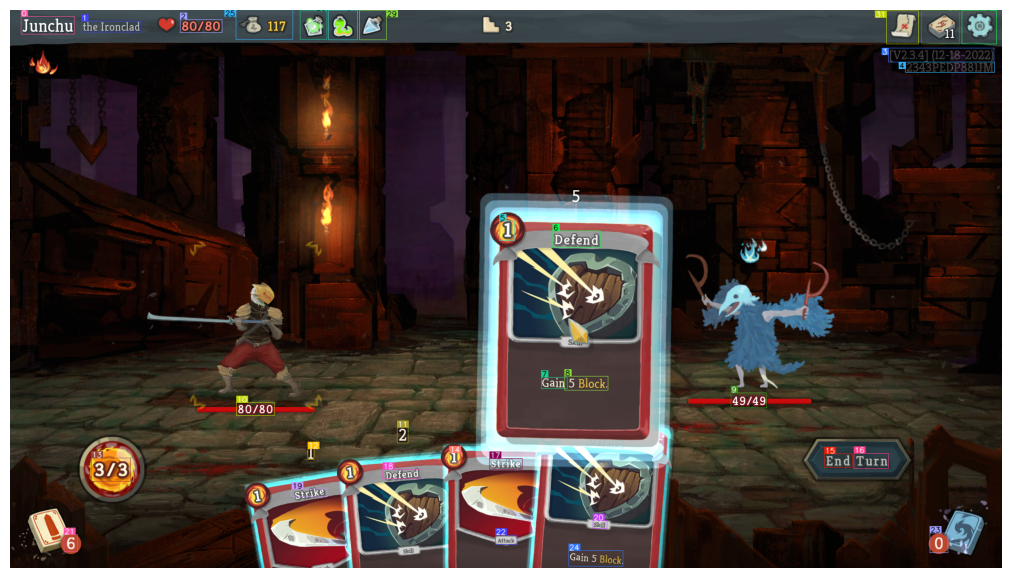

In [18]:

# 6. 可视化检测结果
print("--- 生成检测结果可视化 ---")
try:
    # save labled_img to scripts/omni_detection_result.png
    # Image.open(io.BytesIO(base64.b64decode(labled_img))).save(f'scripts/omni_detection_result.png')

    # in Notebook, plot directly to the following output
    img = Image.open(io.BytesIO(base64.b64decode(labled_img_2)))
    plt.figure(figsize=(12.8, 10.8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
except Exception as e:
    print(f"可视化生成失败: {e}")


In [19]:
# 测试混合查询方法
print("\n=== 测试 query_collection_mixed 方法 ===")

# 测试前5个对象的混合查询
for i, obj in enumerate(detected_objects_2):
    print(f"\n--- 测试对象 {i+1} ---")
    print(f"类型: {obj['type']}")
    print(f"内容: {obj.get('content', 'N/A')}")
    print(f"边界框: {obj['bbox']}")
    
    try:
        # 使用混合查询方法
        mixed_results = vector_memory.query_collection_mixed(
            query_obj=obj,
            top_k=2,
            text_weight=0.5,
            image_weight=0.2,
            bbox_weight=0.7
        )
        
        print(f"找到 {len(mixed_results)} 个混合相似结果:")
        for j, result in enumerate(mixed_results):
            print(f"  结果 {j+1}:")
            print(f"    类型: {result['type']}")
            print(f"    内容: {result.get('content', 'N/A')}")
            print(f"    综合相似度: {result['mixed_similarity']:.4f}")
            print(f"    text: {result['text_similarity']:.4f}")
            print(f"    raw pixel: {result['image_similarity']:.4f}")
            print(f"    bbox pos: {result['bbox_similarity']:.4f}")
            print(f"    bbox: {result['bbox']}")
            print()
    
    except Exception as e:
        print(f"混合查询出错: {e}")

print("\n=== 混合查询测试完成 ===")


=== 测试 query_collection_mixed 方法 ===

--- 测试对象 1 ---
类型: text
内容: Junchu
边界框: [21, 14, 102, 34]
找到 2 个混合相似结果:
  结果 1:
    类型: text
    内容: Junchu
    综合相似度: 0.9448
    text: 1.0000
    raw pixel: 0.6208
    bbox pos: 0.9980
    bbox: [23, 17, 102, 29]

  结果 2:
    类型: text
    内容: the Ironclad
    综合相似度: 0.8345
    text: 0.8623
    raw pixel: 0.6165
    bbox pos: 0.8770
    bbox: [136, 21, 118, 24]


--- 测试对象 2 ---
类型: text
内容: the Ironclad
边界框: [138, 23, 115, 21]
找到 2 个混合相似结果:
  结果 1:
    类型: text
    内容: the Ironclad
    综合相似度: 0.9457
    text: 1.0005
    raw pixel: 0.6186
    bbox pos: 1.0000
    bbox: [136, 21, 118, 24]

  结果 2:
    类型: icon
    内容: 80/80
    综合相似度: 0.8726
    text: 0.8958
    raw pixel: 0.9006
    bbox pos: 0.8480
    bbox: [273, 1, 148, 61]


--- 测试对象 3 ---
类型: text
内容: 80/80
边界框: [329, 20, 81, 25]
找到 2 个混合相似结果:
  结果 1:
    类型: icon
    内容: 80/80
    综合相似度: 0.9789
    text: 1.0000
    raw pixel: 0.9291
    bbox pos: 0.9780
    bbox: [273, 1, 148, 61]

  结果 2:
  

In [20]:
# 添加准确性检测模块
print("\n=== 混合查询准确性统计 ===")

correct_matches = 0
total_queries = 0
mixed_similarity_scores = []
accuracy_details = []

for i, obj in enumerate(detected_objects_2):
    try:
        mixed_results = vector_memory.query_collection_mixed(
            query_obj=obj,
            top_k=2,
            text_weight=0.5,
            image_weight=0.2,
            bbox_weight=0.7
        )
        
        total_queries += 1
        query_correct = False
        
        # 检查前2个结果中是否有正确匹配
        for result in mixed_results[:2]:
            # 收集相似度分数
            mixed_similarity_scores.append(result['mixed_similarity'])
            
            # 判断是否为正确匹配（可以根据实际需求调整判断条件）
            # 这里假设同一个object_id或者相似度很高表示正确匹配
            if (result.get('object_id') == obj.get('object_id') or 
                result['mixed_similarity'] > 0.8):  # 可调整阈值
                query_correct = True
                break
        
        if query_correct:
            correct_matches += 1
            
        accuracy_details.append({
            'query_id': i+1,
            'query_type': obj['type'],
            'correct': query_correct,
            'top_similarity': mixed_results[0]['mixed_similarity'] if mixed_results else 0
        })
        
    except Exception as e:
        print(f"查询 {i+1} 出错: {e}")

# 统计结果
accuracy = correct_matches / total_queries if total_queries > 0 else 0
avg_similarity = sum(mixed_similarity_scores) / len(mixed_similarity_scores) if mixed_similarity_scores else 0

print(f"总查询数: {total_queries}")
print(f"正确匹配数: {correct_matches}")
print(f"准确率: {accuracy:.2%}")
print(f"平均混合相似度: {avg_similarity:.4f}")
print(f"最高相似度: {max(mixed_similarity_scores):.4f}" if mixed_similarity_scores else "无数据")
print(f"最低相似度: {min(mixed_similarity_scores):.4f}" if mixed_similarity_scores else "无数据")

# 详细结果
print("\n详细结果:")
for detail in accuracy_details:
    status = "✓" if detail['correct'] else "✗"
    print(f"{status} 查询{detail['query_id']} ({detail['query_type']}): 最高相似度 {detail['top_similarity']:.4f}")


=== 混合查询准确性统计 ===
总查询数: 32
正确匹配数: 30
准确率: 93.75%
平均混合相似度: 0.9111
最高相似度: 0.9990
最低相似度: 0.6921

详细结果:
✓ 查询1 (text): 最高相似度 0.9448
✓ 查询2 (text): 最高相似度 0.9457
✓ 查询3 (text): 最高相似度 0.9789
✓ 查询4 (text): 最高相似度 0.9469
✓ 查询5 (text): 最高相似度 0.9473
✗ 查询6 (text): 最高相似度 0.7483
✗ 查询7 (text): 最高相似度 0.7154
✓ 查询8 (text): 最高相似度 0.8017
✓ 查询9 (text): 最高相似度 0.8087
✓ 查询10 (text): 最高相似度 0.9464
✓ 查询11 (text): 最高相似度 0.9470
✓ 查询12 (text): 最高相似度 0.9452
✓ 查询13 (text): 最高相似度 0.8605
✓ 查询14 (text): 最高相似度 0.9462
✓ 查询15 (text): 最高相似度 0.9151
✓ 查询16 (text): 最高相似度 0.9469
✓ 查询17 (text): 最高相似度 0.9454
✓ 查询18 (text): 最高相似度 0.8841
✓ 查询19 (text): 最高相似度 0.9427
✓ 查询20 (text): 最高相似度 0.8194
✓ 查询21 (text): 最高相似度 0.9232
✓ 查询22 (text): 最高相似度 0.9450
✓ 查询23 (text): 最高相似度 0.9201
✓ 查询24 (text): 最高相似度 0.9464
✓ 查询25 (text): 最高相似度 0.9058
✓ 查询26 (icon): 最高相似度 0.9938
✓ 查询27 (icon): 最高相似度 0.9987
✓ 查询28 (icon): 最高相似度 0.9989
✓ 查询29 (icon): 最高相似度 0.9990
✓ 查询30 (icon): 最高相似度 0.9983
✓ 查询31 (icon): 最高相似度 0.9987
✓ 查询32 (icon): 最高相似度 0.9986
